<a href="https://colab.research.google.com/github/nedokormysh/NLP_Fontanka/blob/main/Fontanka_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import datetime
from wordcloud import WordCloud, STOPWORDS
import datetime

import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")

sns.set(style="darkgrid")
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Загрузка данных

In [88]:
df = pd.DataFrame()

In [89]:
for i in range(45):
    df_ = pd.read_csv(f'https://github.com/nedokormysh/NLP_Fontanka/raw/main/data/fontanka_intermediate_{i}.csv')
    df = pd.concat([df, df_])

# EDA

Хотим решать задачу классификации текстов по темам.

Выведем несколько строк

In [90]:
df.head(5)

url  \
0  https://www.fontanka.ru/2022/01/01/70356794/   
1  https://www.fontanka.ru/2022/01/01/70356791/   
2  https://www.fontanka.ru/2022/01/01/70356788/   
3  https://www.fontanka.ru/2022/01/01/70356782/   
4  https://www.fontanka.ru/2022/01/01/70356677/   

                                               title  \
0  Смогли повторить. Петербуржцы продолжили празд...   
1  Как обложка альбома. Первое в 2022 году северн...   
2  Роулинг достали из архива. Какие тайны раскрыл...   
3  Первый закат нового года засняли петербуржцы в...   
4        В Хургаде 1 января выпал град. Туристы рады   

                                             content     topic  \
0  Вечер 1 января показал: у петербуржцев достато...     Город   
1  Охотники за огнями Авроры начали новый год за ...     Город   
2  Поклонники Гарри Поттера со всего мира смотрят...  Общество   
3  Фото на фоне закатного солнца сняли жители Пет...     Город   
4  Египетский курорт засыпало градом 1 января. В ...  Общество   

              datetime  views  comments_amount  
0  2022-01-01 23:15:00  30940               19  
1  2022-01-01 22:33:00  13062                3  
2  2022-01-01 22:20:00  12050                0  
3  2022-01-01 21:25:00  13591                1  
4  2022-01-01 20:33:00  15892                9

In [91]:
# Переводим тэги к нижнему регистру
df['topic']= df['topic'].apply(lambda x: x.lower())

Размер датасета

In [92]:
df.shape

(46348, 7)

### Общая информация о датафрейме

In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 46348 entries, 0 to 1039
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   url              46348 non-null  object
 1   title            46348 non-null  object
 2   content          46324 non-null  object
 3   topic            46348 non-null  object
 4   datetime         46348 non-null  object
 5   views            46348 non-null  int64 
 6   comments_amount  46348 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 3.8+ MB


### Кол-во пропусков

In [94]:
df.isna().sum()

url                 0
title               0
content            24
topic               0
datetime            0
views               0
comments_amount     0
dtype: int64

In [95]:
print(f"Доля пропусков в признаке 'content': {round(df['content'].isna().sum() / df.shape[0]*100, 2)}%")

Доля пропусков в признаке 'content': 0.05%


На некоторых страницах сервер обрывал соединение. Но количество таких строк мало, поэтому предполагаю, что можно не использовать эти пропущенные объекты.

In [96]:
df.dropna(inplace=True)

In [97]:
df.isna().any().any()

False

### Основные описательные статистики

In [98]:
df.describe()

views  comments_amount
count  4.632400e+04     46324.000000
mean   1.521706e+04        23.928978
std    2.405670e+04        38.418683
min    3.320000e+02         0.000000
25%    6.355000e+03         4.000000
50%    9.542000e+03        12.000000
75%    1.590600e+04        29.000000
max    1.635672e+06       989.000000

In [99]:
df.describe(exclude='int')

url  \
count                                          46324   
unique                                         46324   
top     https://www.fontanka.ru/2022/01/01/70356794/   
freq                                               1   

                                          title  \
count                                     46324   
unique                                    46237   
top     «Итоги недели» с Андреем Константиновым   
freq                                         41   

                                                  content         topic  \
count                                               46324         46324   
unique                                              46324            17   
top     Вечер 1 января показал: у петербуржцев достато...  происшествия   
freq                                                    1         15228   

                   datetime  
count                 46324  
unique                46093  
top     2022-04-25 14:55:00  
freq                      3

### Распределение новостей по темам

**Гипотеза:** есть зависимость количества новостей по тематике.

In [100]:
# Размер каждой категории
df.topic.value_counts()

topic
происшествия     15228
общество         13418
город             7778
власть            3337
спорт             1611
бизнес            1582
политика           936
авто               580
финансы            565
строительство      437
технологии         291
туризм             224
доброе дело        189
образ жизни         93
недвижимость        39
особое мнение       15
доктор питер         1
Name: count, dtype: int64

У нас сильная несбалансированность в выборке, причём некоторые темы встречаются абсолютно минимальное количество раз, обучиться на них мы не сможем, поэтому решил выбросить их из наших данных

In [101]:
# Получаем количество значений в столбце topic
topic_counts = df.topic.value_counts()

# Получаем топ 10 топиков по количеству встречающихся
top_topics = topic_counts.head(10)

# Фильтруем датафрейм df, оставив только строки с топовыми топиками
df = df[df.topic.isin(top_topics.index)]

Распределение по категориям новостей несбалансированное.

In [102]:
df.topic.value_counts()

topic
происшествия     15228
общество         13418
город             7778
власть            3337
спорт             1611
бизнес            1582
политика           936
авто               580
финансы            565
строительство      437
Name: count, dtype: int64

In [103]:
df.shape

(45472, 7)

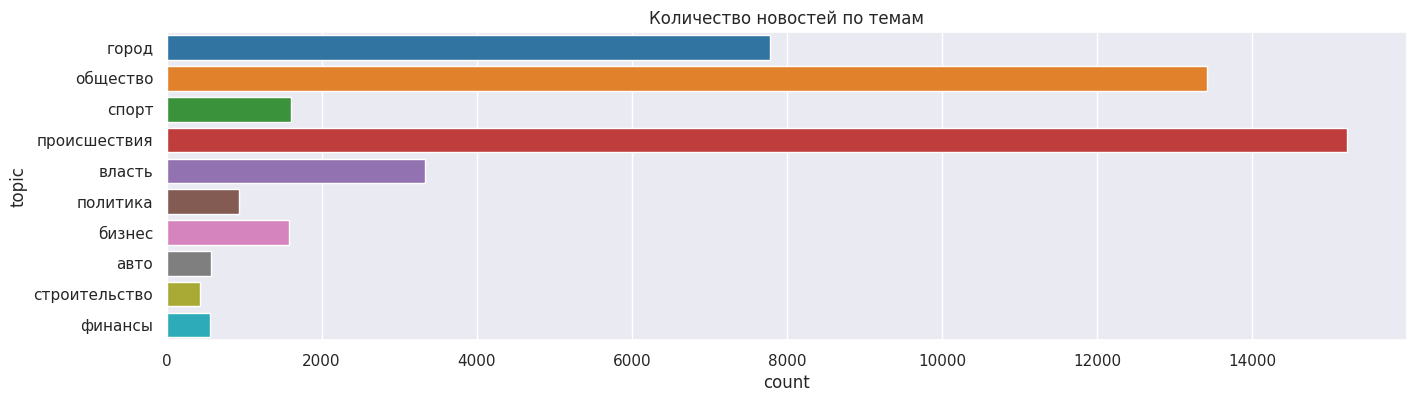

In [104]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(16,4))
sns.countplot(y=df["topic"],
              hue=df["topic"],
              palette='tab10',
              ax=ax,
              legend=False)
plt.title('Количество новостей по темам');

**Выводы:**
- Зависимость количества новостей от тематики есть
- Больше всего статей у нас по теме проишествия и общество
- Сильная несбалансированность данных

### Распределение количества новостей по годам, месяцам и дням недели

**Гипотеза:** у нас есть зависимость распределения количества новостей по временным шкалам.

In [105]:
df['datetime'] = pd.to_datetime(df['datetime'], utc=True)

In [106]:
# df['date'] = df['datetime'].dt.date
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.strftime("%B")
df['weekday'] = df['datetime'].dt.strftime('%A')
df['hour'] = df['datetime'].dt.hour

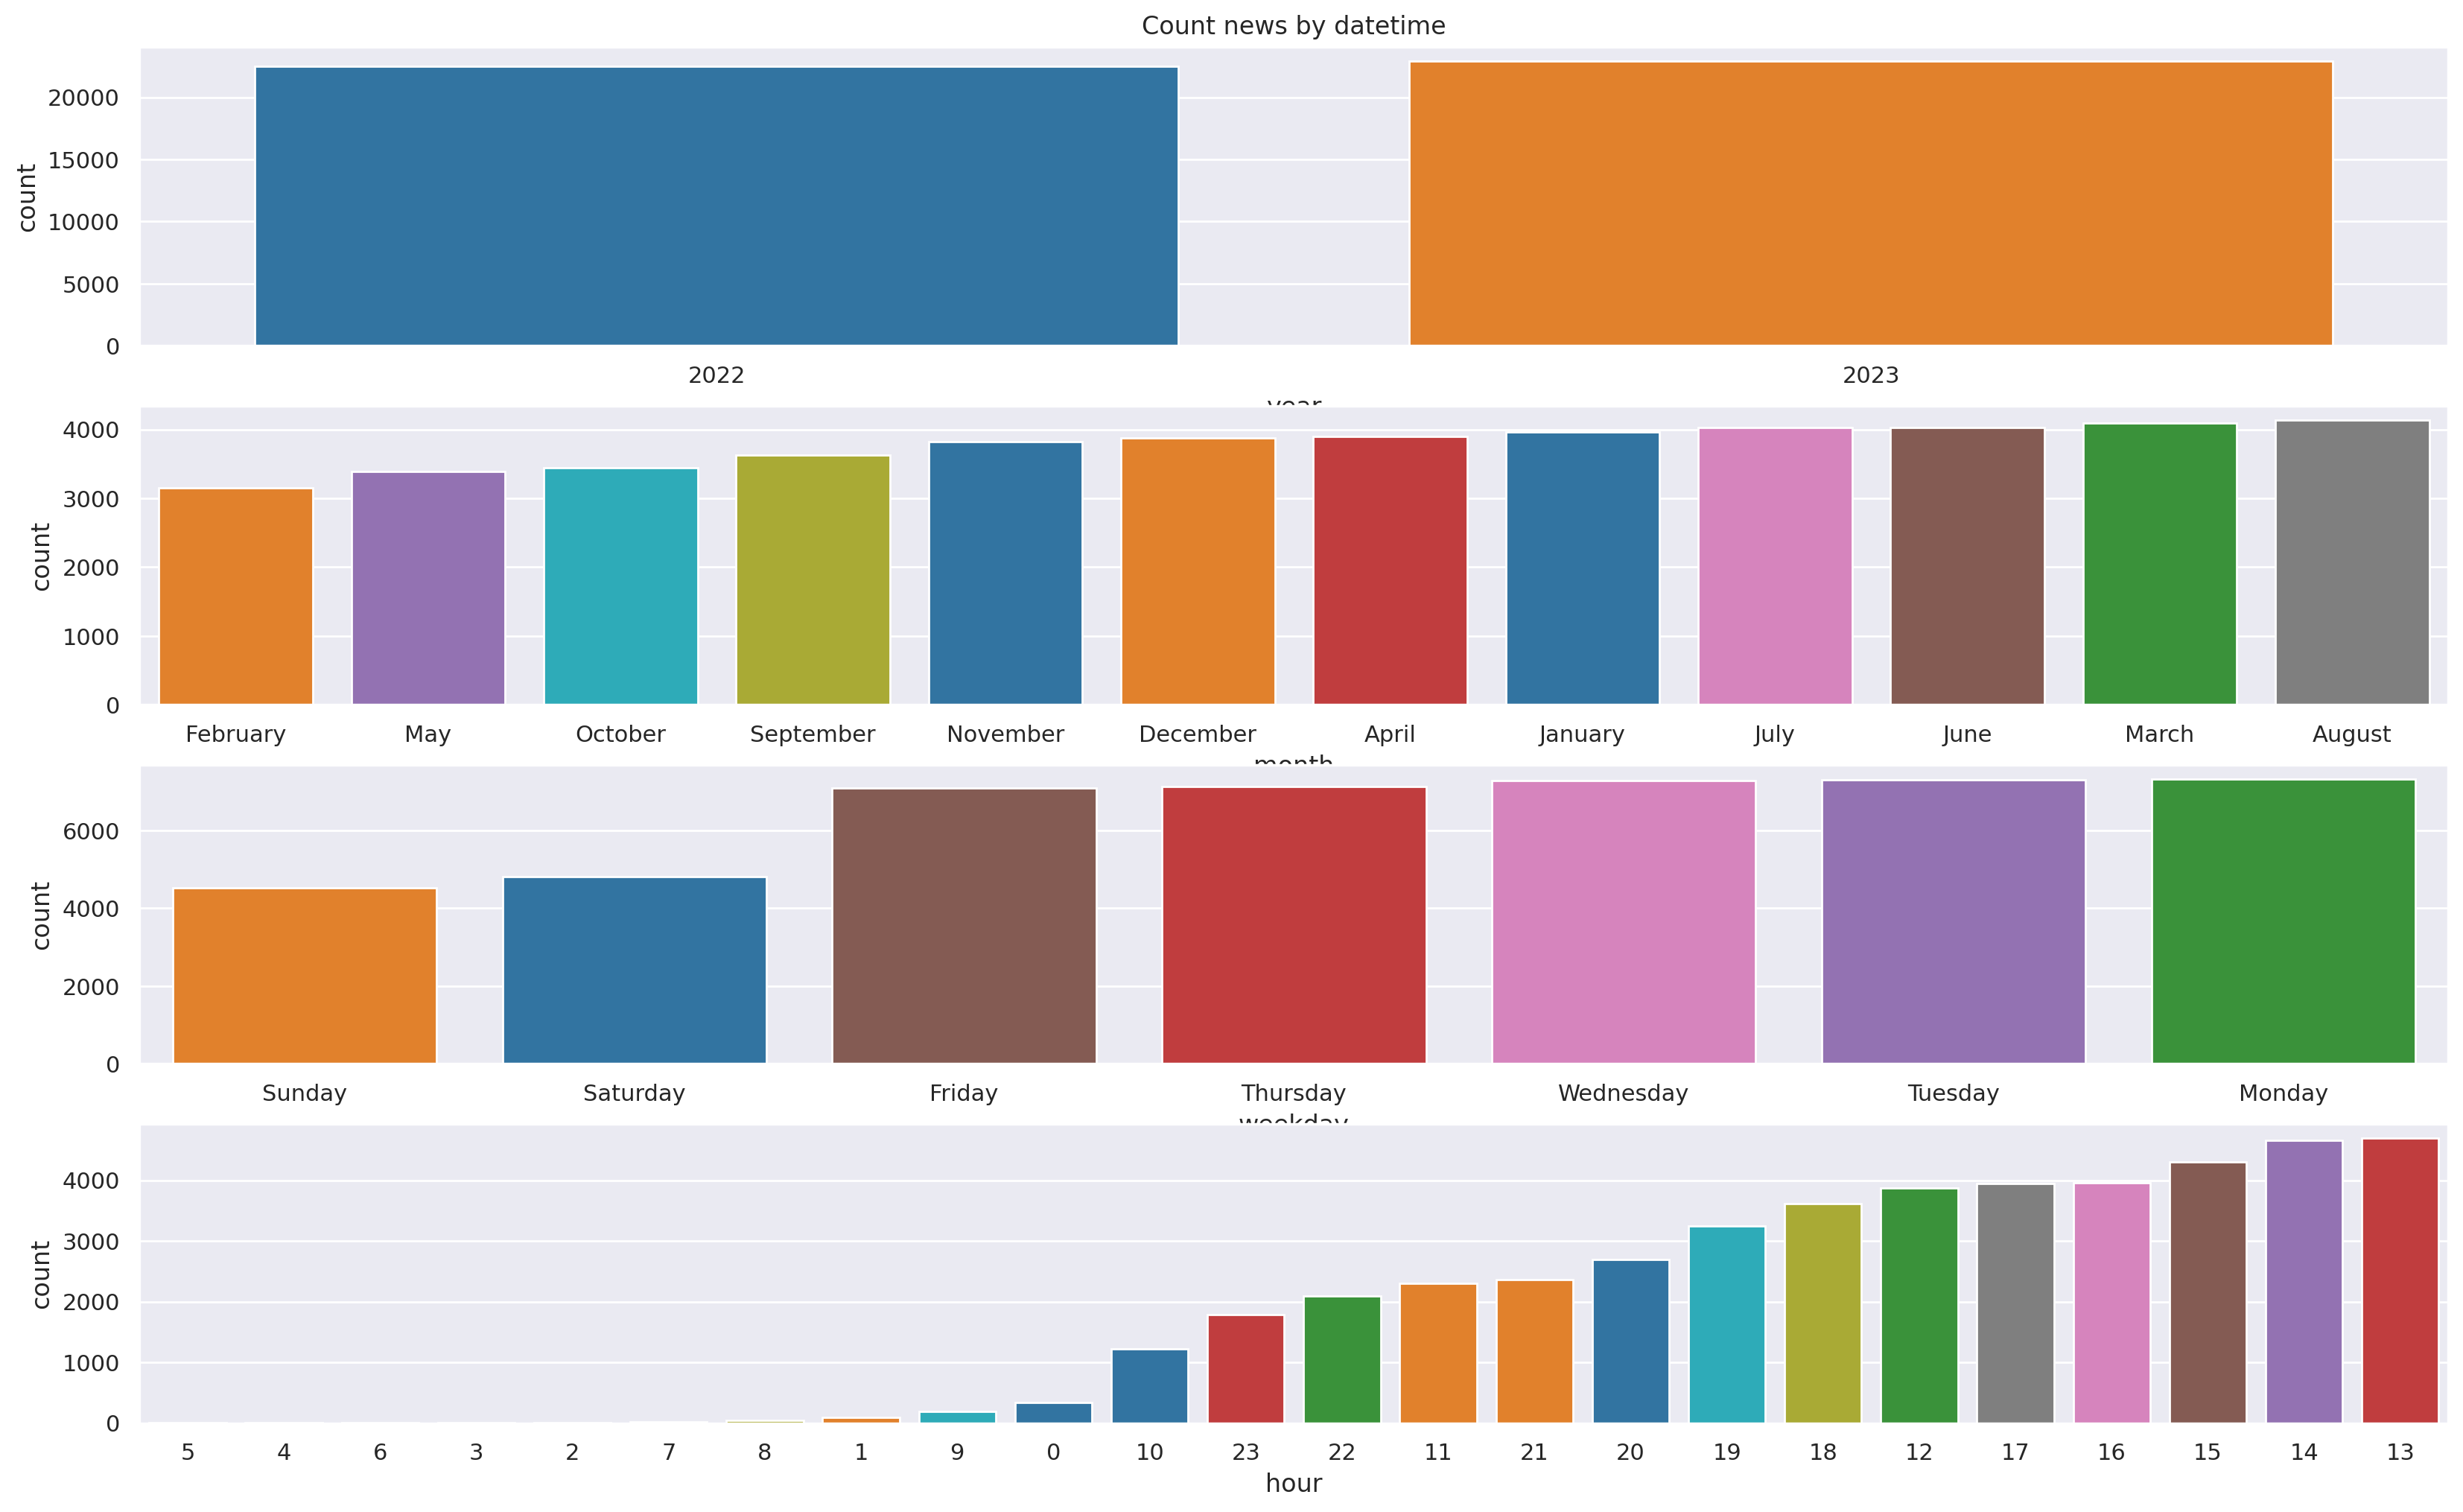

In [107]:
fig, axs = plt.subplots(4, 1, figsize=(20, 12), dpi=200)
for ind, col in enumerate(['year', 'month', 'weekday', 'hour']):
    sns.countplot(x=df[col],
                  hue=df[col],
                  legend=False,
                  palette='tab10',
                  ax=axs[ind],
                  order=df[col].value_counts(ascending=True).index)
axs[0].set_title('Count news by datetime');

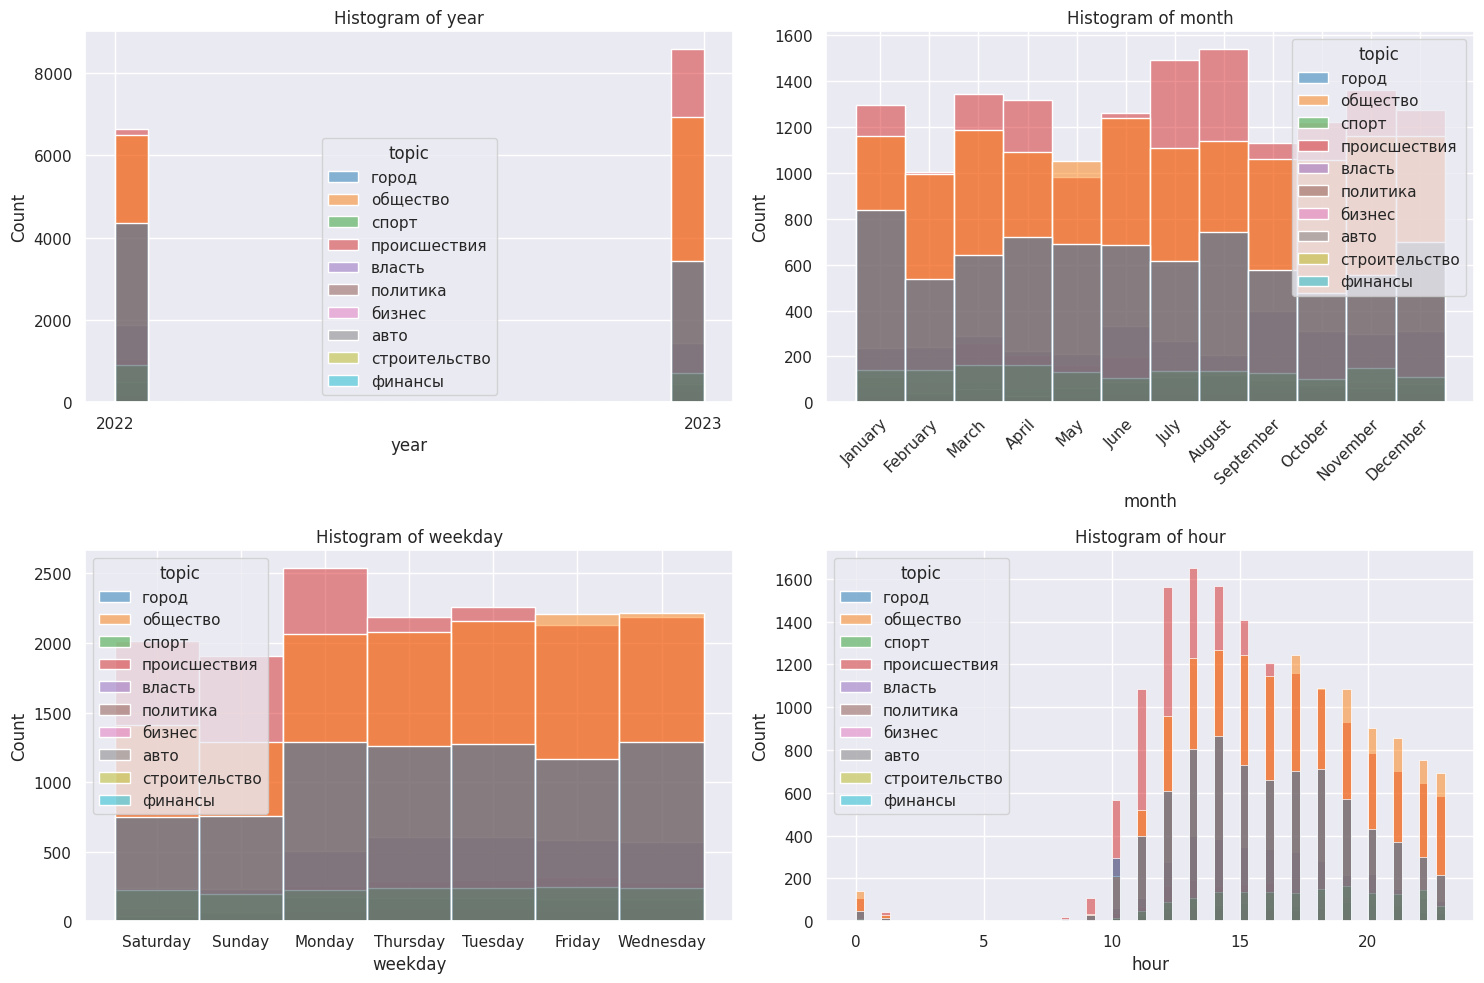

In [108]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

columns = ['year', 'month', 'weekday', 'hour']

for i, col_name in enumerate(columns):
    row = i // 2
    col = i % 2

    sns.histplot(data=df,
                 x=col_name,
                 hue='topic',
                 ax=axes[row, col],
                 palette='tab10',
                #  multiple="stack"
                 )

    axes[row, col].set_title(f'Histogram of {col_name}')

    # Если текущий столбец - 'year', то устанавливаем шаг сетки равным 1
    if col_name == 'year':
        axes[row, col].xaxis.set_major_locator(plt.MultipleLocator(1))

     # Если текущий столбец - 'month', то поворачиваем подписи на оси X на 45 градусов
    if col_name == 'month':
        plt.setp(axes[row, col].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

plt.tight_layout()
plt.show()

**Выводы:**
- данные за 2 года
- у нас есть зависимость публикации разных тем и количества публикаций от времени
- больше всего статей приходится на август. меньше всего на февраль - вероятно из-за количества дней в этом месяце
- по выходным дням у нас существенное уменьшение количества публикуемых новостей.
- можно видеть, что, например, происшествия публикуются чаще всего с утра и в выходные дни

### Распределение по числу просмотров

**Гипотеза:** статьи на определенные темы привлекают больше просмотров, чем статьи на другие темы.

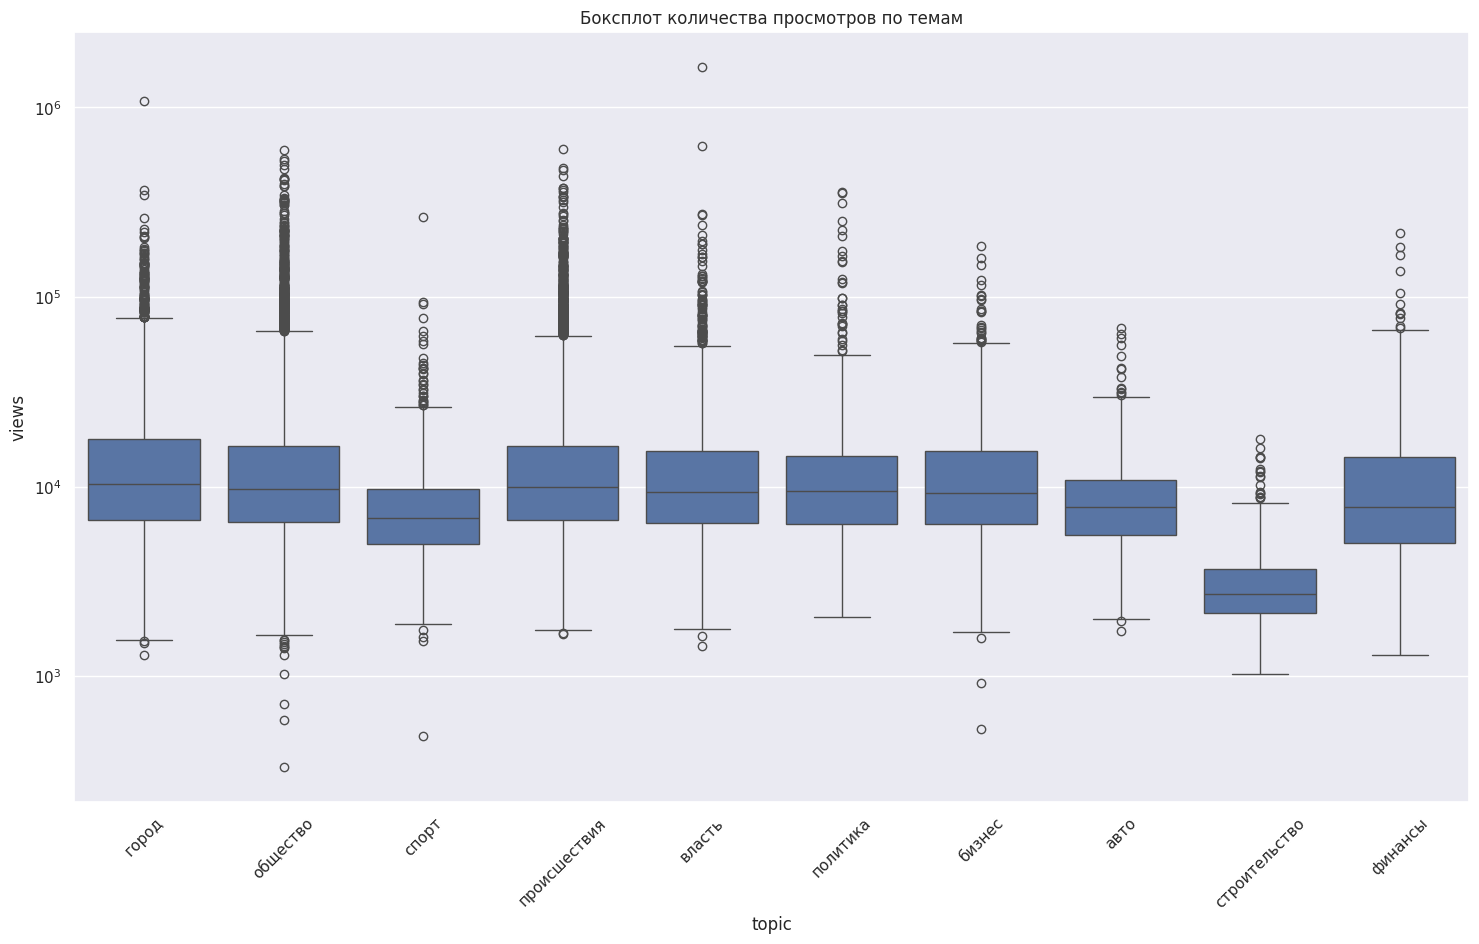

In [109]:
fig, ax = plt.subplots(1, 1, figsize=(18, 10), dpi=100)
# получаем количество уникальных значений в столбце topic
n_topics = len(df.topic.unique())
ax.set_xticks(range(n_topics))
ax.set_xticklabels(df.topic.unique(), rotation=45)
# устанавливаем логарифмическую шкалу по вертикали
ax.set_yscale('log')
sns.boxplot(x="topic", y="views", data=df, ax=ax)
plt.title('Боксплот количества просмотров по темам');

**Выводы:**
- у нас есть большие выбросы по количеству просмотров, особенно по тематике "власть"
- также у нас есть большие хвосты в распределениях
- по темам "строительство", "спорт", "авто" у нас просмотры ниже, чем в других тематиках

#### Распределение количества просмотров по всем данным

<ipython-input-110-f0dea50e13fd>:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(


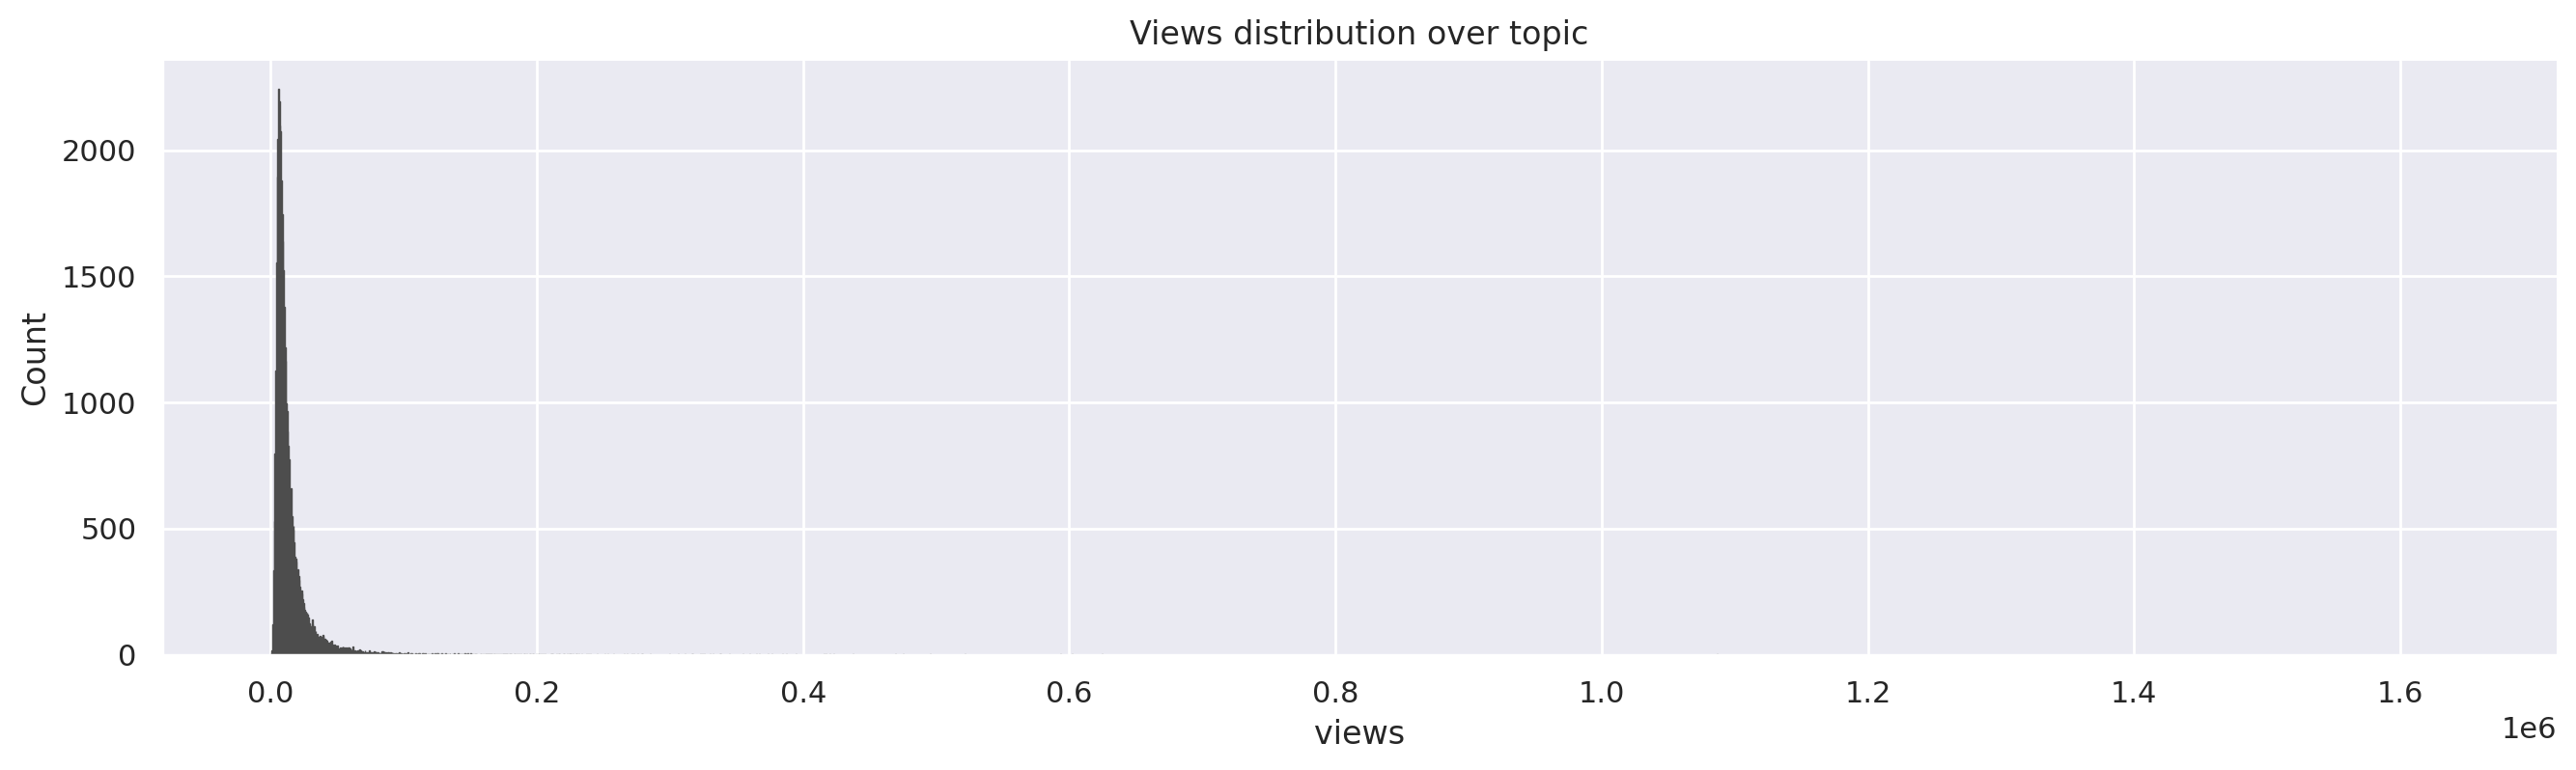

In [110]:
fig, axs = plt.subplots(1, 1, figsize=(16, 4), dpi=200)
sns.despine(fig)

sns.histplot(
    df,
    x="views",
    edgecolor=".3",
    palette="coolwarm",
    linewidth=.5,
);
axs.set_title('Views distribution over topic');

Форма распределения похожа на логнормальное распределение. Добавим еще один признак - логарифм количества просмотров, сдвинутого на единицу, поскольку количество просмотров может принимать значение ноль.

In [111]:
df['log_views'] = np.log1p(df['views'])

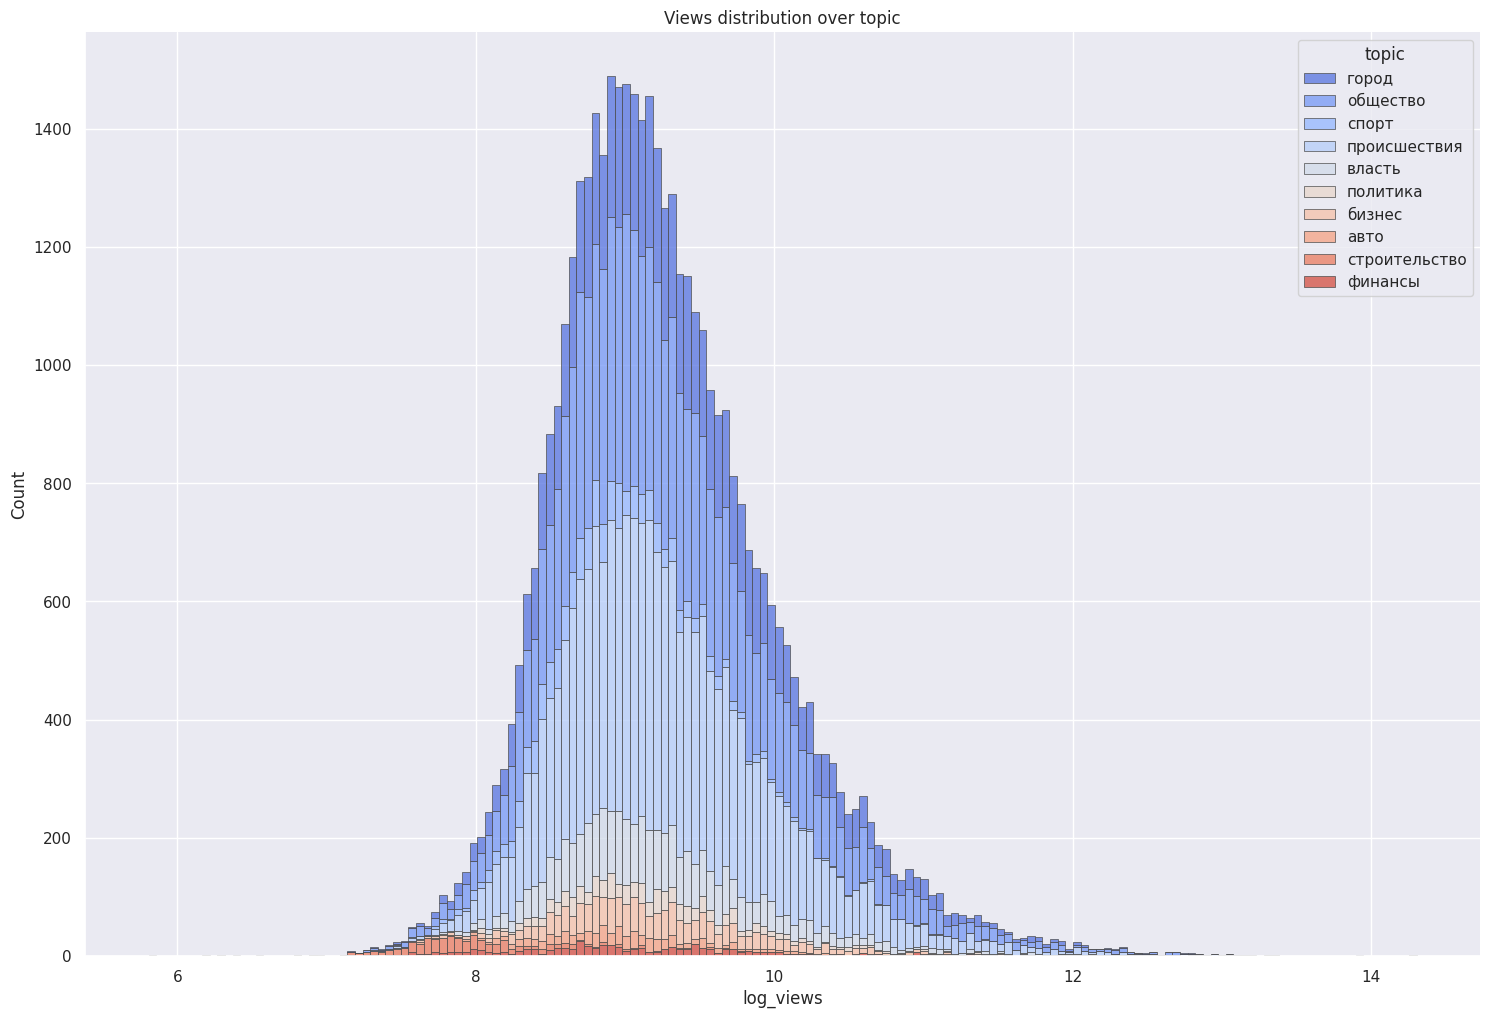

In [112]:
fig, axs = plt.subplots(1, 1, figsize=(18, 12), dpi=100)
sns.despine(fig)

sns.histplot(
    df,
    x="log_views",
    hue="topic",
    multiple="stack",
    edgecolor=".3",
    palette="coolwarm",
    linewidth=.5,
);
axs.set_title('Views distribution over topic');

In [113]:
df.groupby('topic').agg(min_views =('views', 'min'),
                        max_views=('views', 'max'),
                        avg_views=('views', 'mean'),
                        total_views=('views', 'sum')).sort_values(by='total_views',
                                                                  ascending=False)

min_views  max_views     avg_views  total_views
topic                                                         
происшествия        1671     602238  15457.572104    235387908
общество             332     593513  16284.659189    218507557
город               1293    1087024  16245.887503    126360513
власть              1450    1635672  14964.108780     49935231
бизнес               527     186488  13453.548040     21283513
политика            2056     358808  15537.833333     14543412
спорт                481     265581   8652.998138     13939980
финансы             1295     218669  13615.440708      7692724
авто                1736      68940   9756.489655      5658764
строительство       1023      17831   3397.302059      1484621

In [114]:
from scipy.stats import mannwhitneyu

# Генерируем выборку из нормального распределения с таким же мат. ожиданием и дисперсией, как у нашей переменной
x = np.random.normal(loc=df['log_views'].mean(), scale=df['log_views'].std(), size=100000)

# Проводим тест Манна-Уитни и получаем p-значимость
U1, p = mannwhitneyu(x, df['log_views'])

print('P-значимость:', p)

# Возьмем границу принятия решения 1%
if p < 0.01:
    print('Распределение количества просмотров можно считать логнормальным')
else:
    print('Распределение количества просмотров нельзя считать логнормальным')

P-значимость: 1.0180449380913929e-30
Распределение количества просмотров можно считать логнормальным


### Распределение по длине заголовка и длине самого текста

**Гипотезы:** есть зависимость длин заголовков в разных темах, а также отличаются длины самих текстов

In [115]:
df['len_title'] = df['title'].str.len()
df['len_content'] = df['content'].str.len()

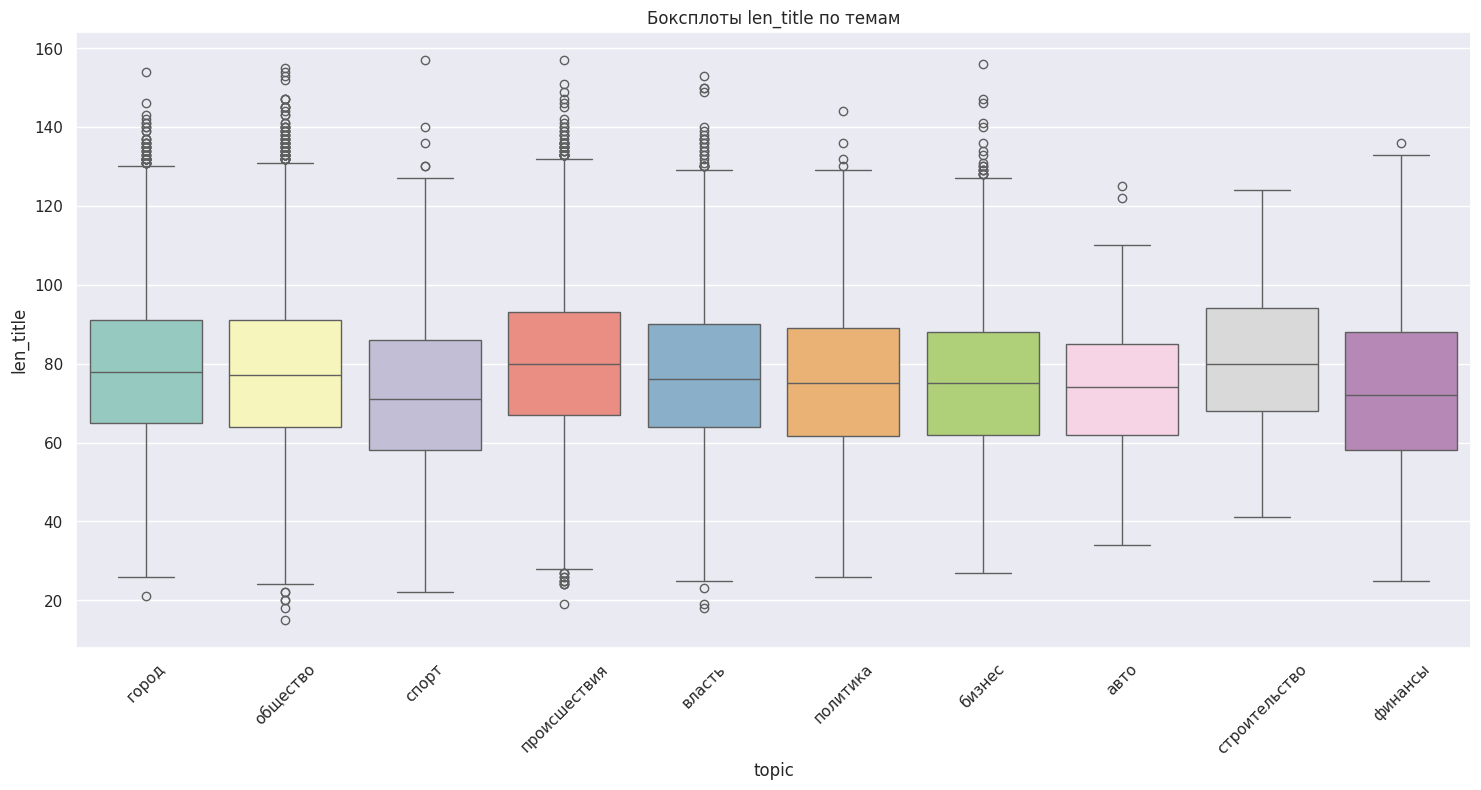

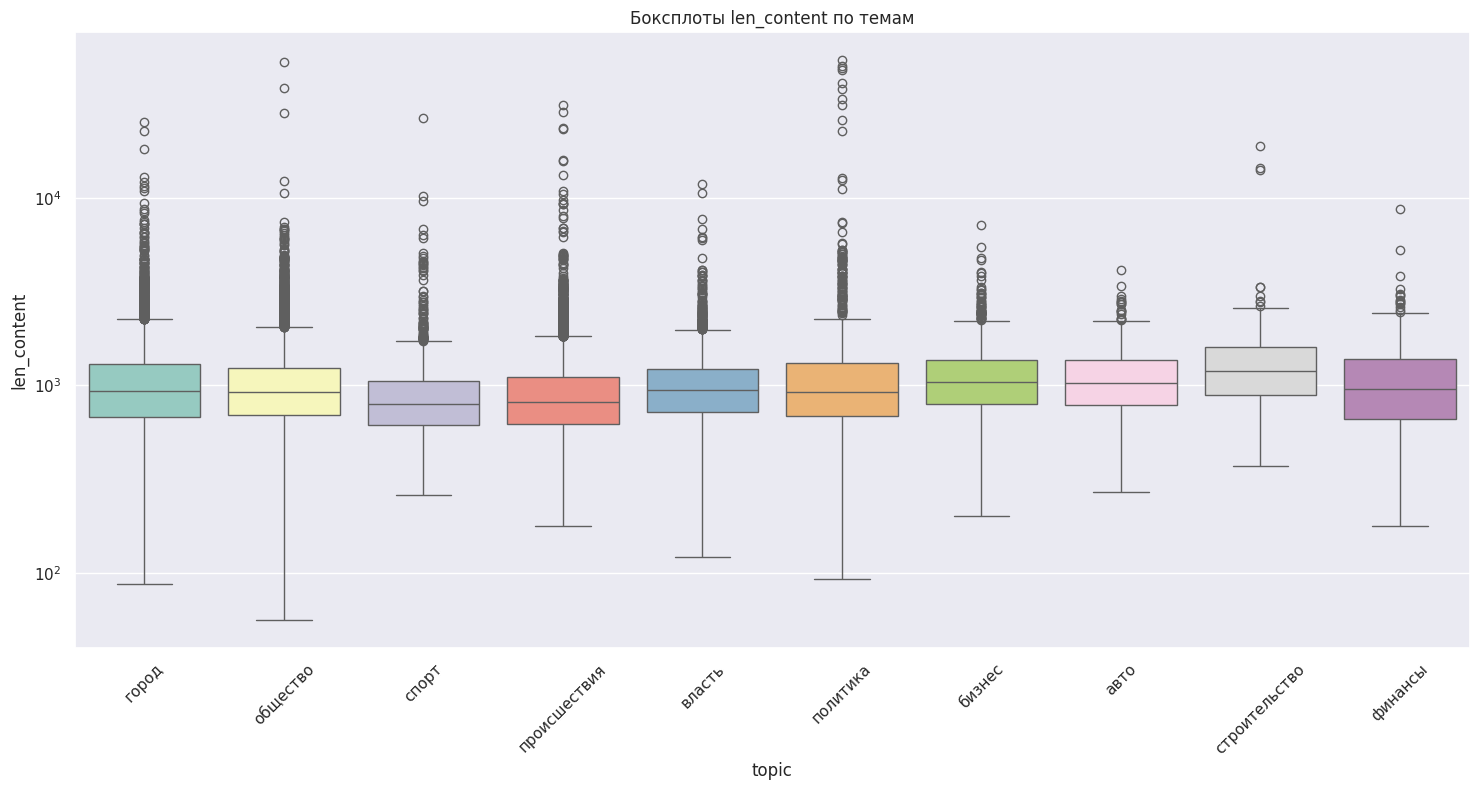

In [119]:
for col in ['len_title', 'len_content']:
    fig, ax = plt.subplots(1, 1, figsize=(18, 8), dpi=100)
    n_topics = len(df.topic.unique())
    # ax.set_xticks(range(n_topics))
    ax.xaxis.set_major_locator(plt.FixedLocator(range(n_topics)))
    ax.set_xticklabels(df.topic.unique(), rotation=45)
    sns.boxplot(x="topic", y=col, data=df, hue="topic", palette="Set3", ax=ax)
    if col == 'len_content':
        ax.set_yscale('log') # Изменяем масштаб оси Y на логарифмический
    plt.title(f'Боксплоты {col} по темам');

In [120]:
# for col in ['len_title', 'len_content']:
#     fig, ax = plt.subplots(1, 1, figsize=(18, 8), dpi=100)
#     n_topics = len(df.topic.unique())
#     # ax.set_xticks(range(n_topics))
#     ax.xaxis.set_major_locator(plt.FixedLocator(range(n_topics)))
#     ax.set_xticklabels(df.topic.unique(), rotation=45)
#     sns.boxplot(x="topic", y=col, data=df, hue="topic", palette="Set3", ax=ax)
#     plt.title(f'Боксплоты {col} по темам');

**Выводы:**
- длина заголовков в большинстве тем в среднем достаточно близка, обычено ниже 80 символов.
- может быть можно говорить, что в тематике "спорт" длина заголовков несколько ниже средней
- по длине текстов у нас во множестве тематик наблюдаются длинные хвосты
- по средней длине текстов особых отличий не наблюдаю, при этом минимальные длины текстов отличаются у разных тематик достаточно сильно

### Наиболее популярные слова в тексте

In [ ]:
stop_words = stopwords.words('russian')
stop_words.extend(['что', 'это', 'так',
                    'вот', 'быть', 'как',
                    'в', '—', 'к', 'за', 'из', 'из-за',
                    'на', 'ок', 'кстати',
                    'который', 'мочь', 'весь',
                    'еще', 'также', 'свой',
                    'ещё', 'самый', 'ул', 'комментарий',
                    'английский', 'язык'])

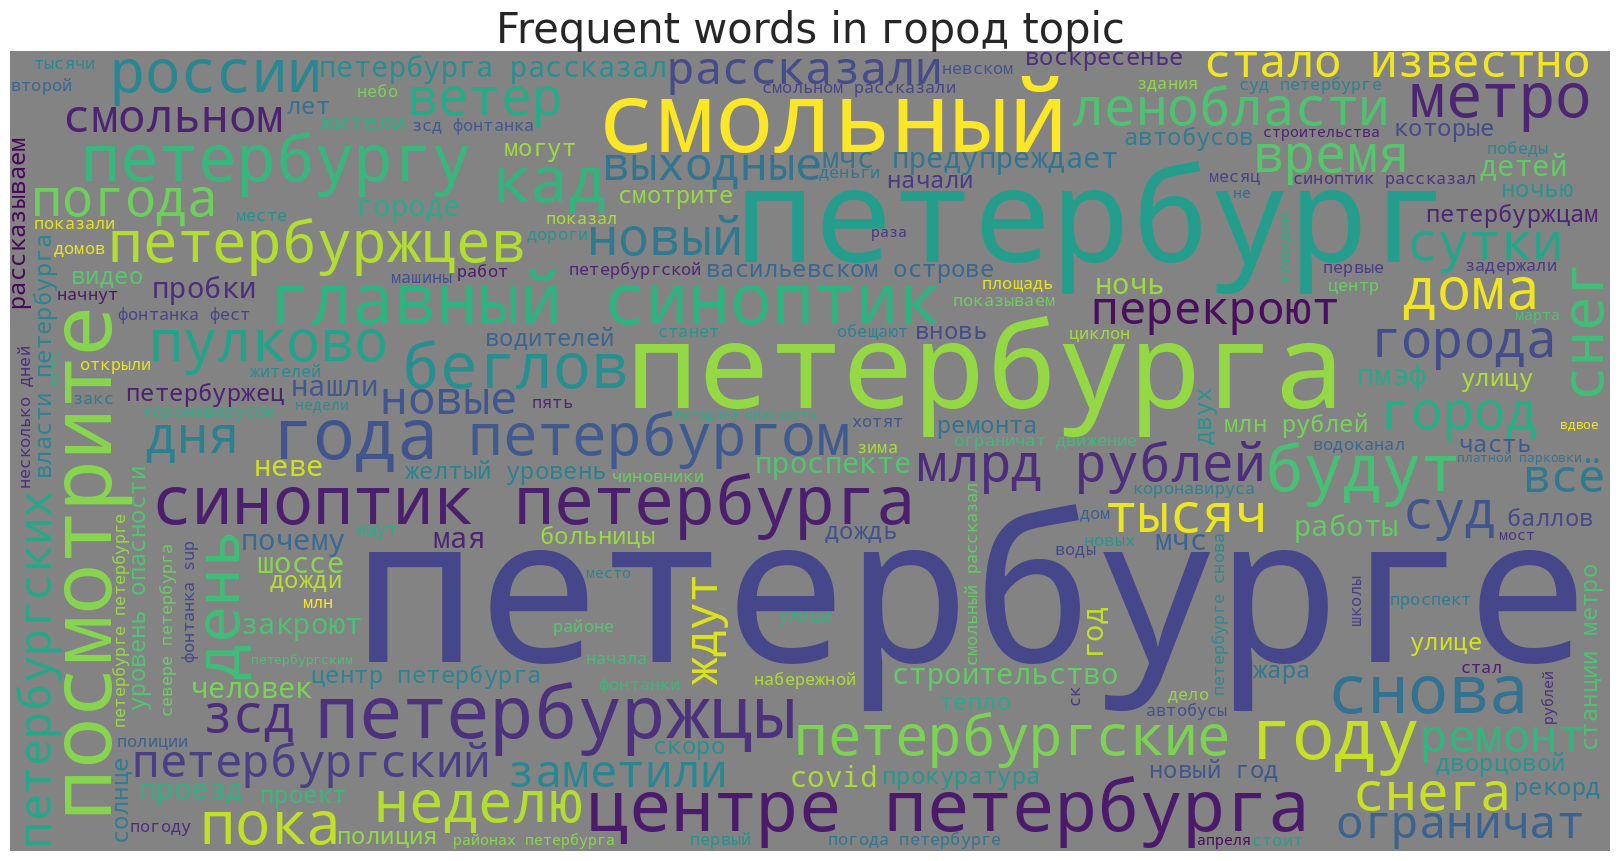

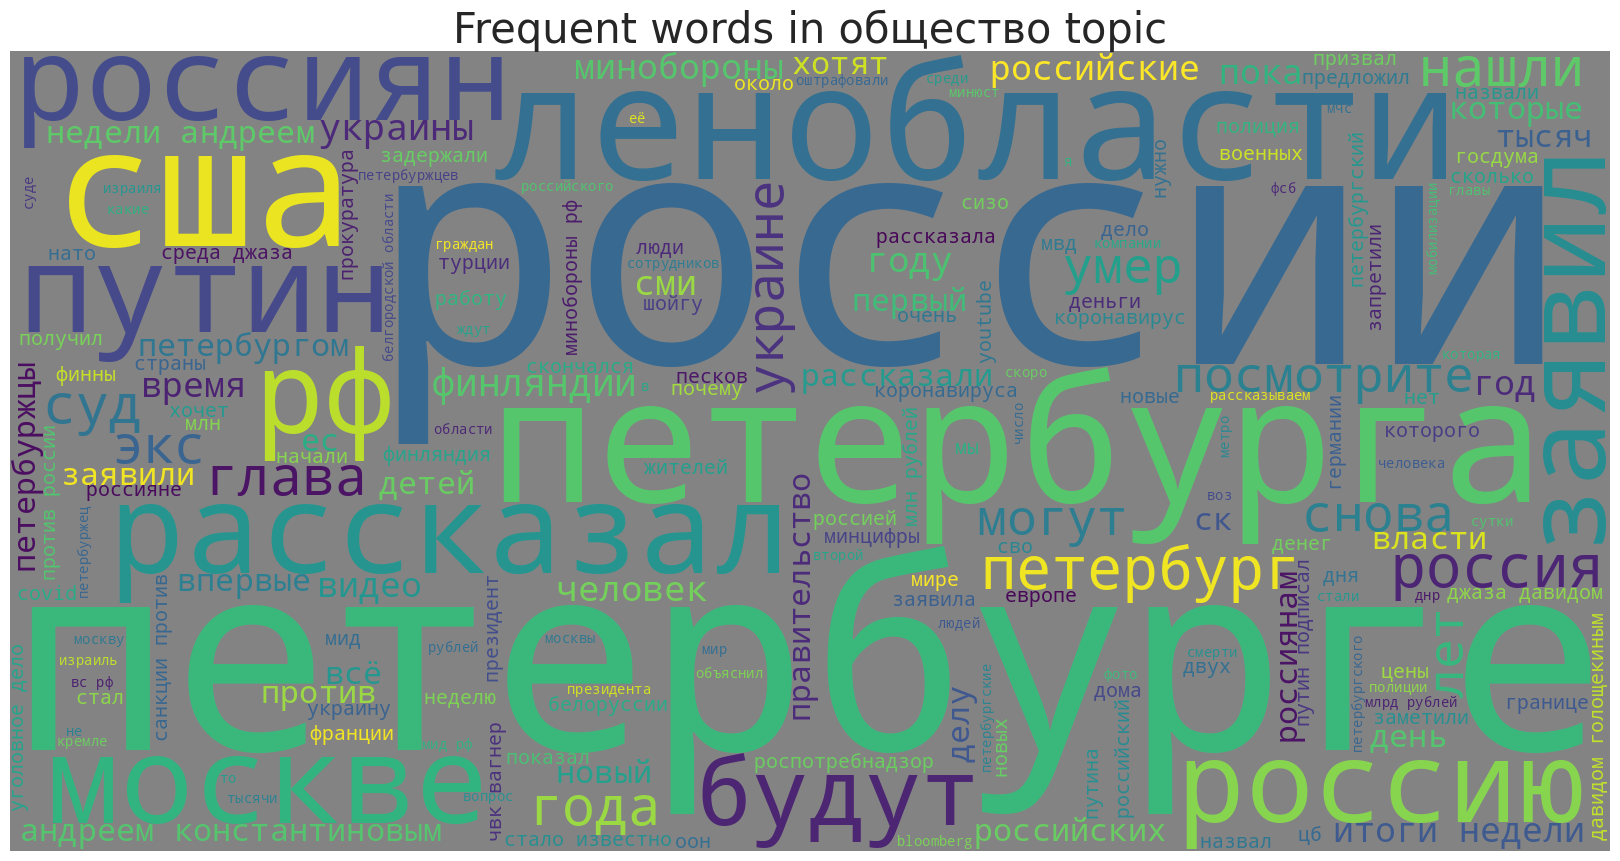

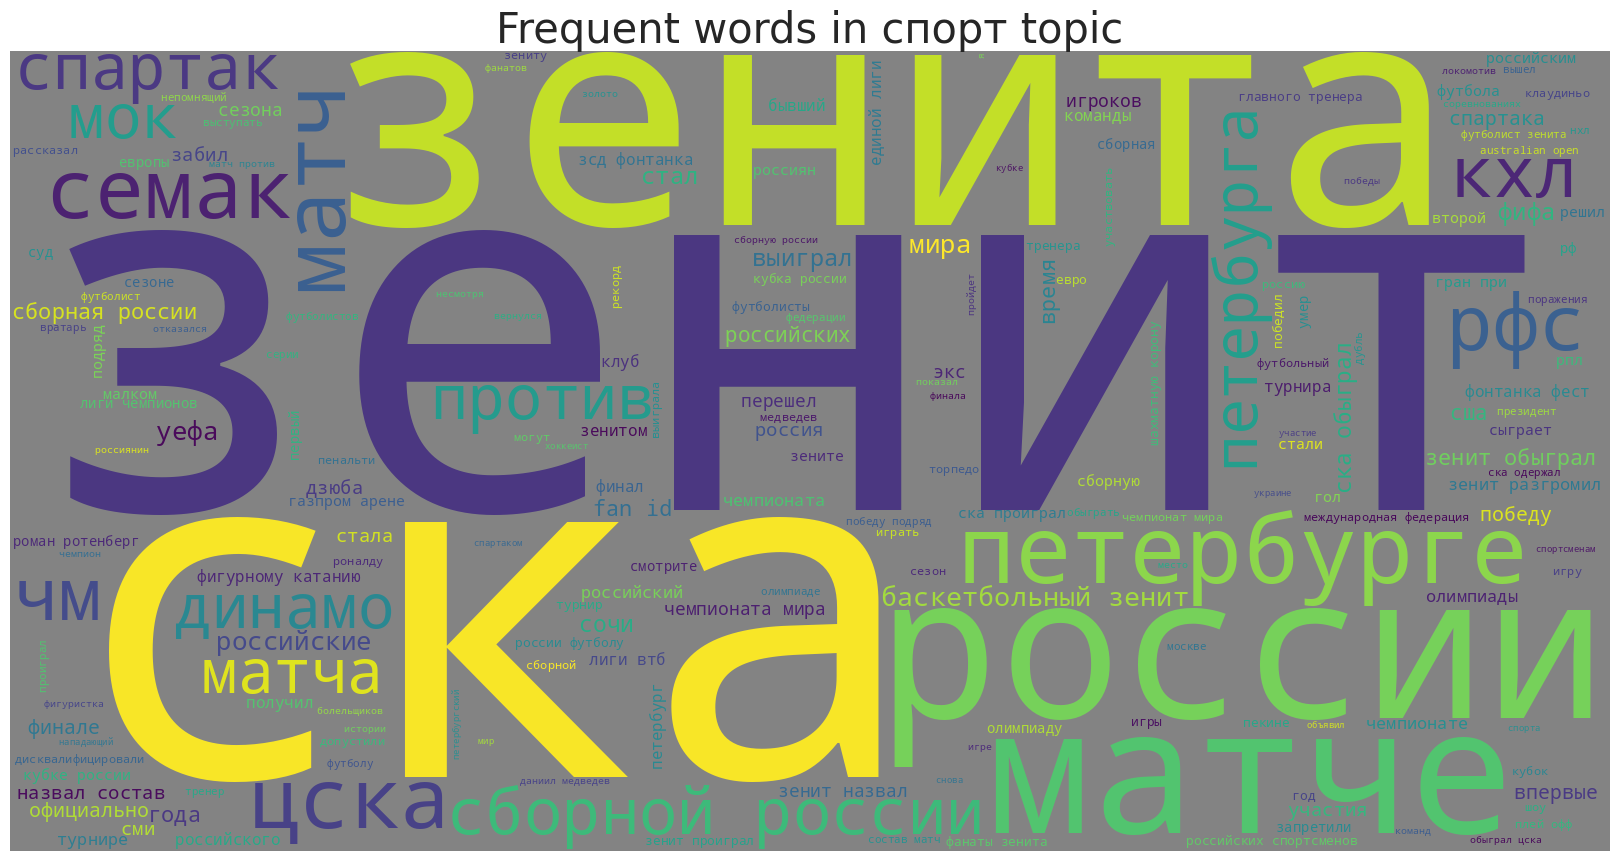

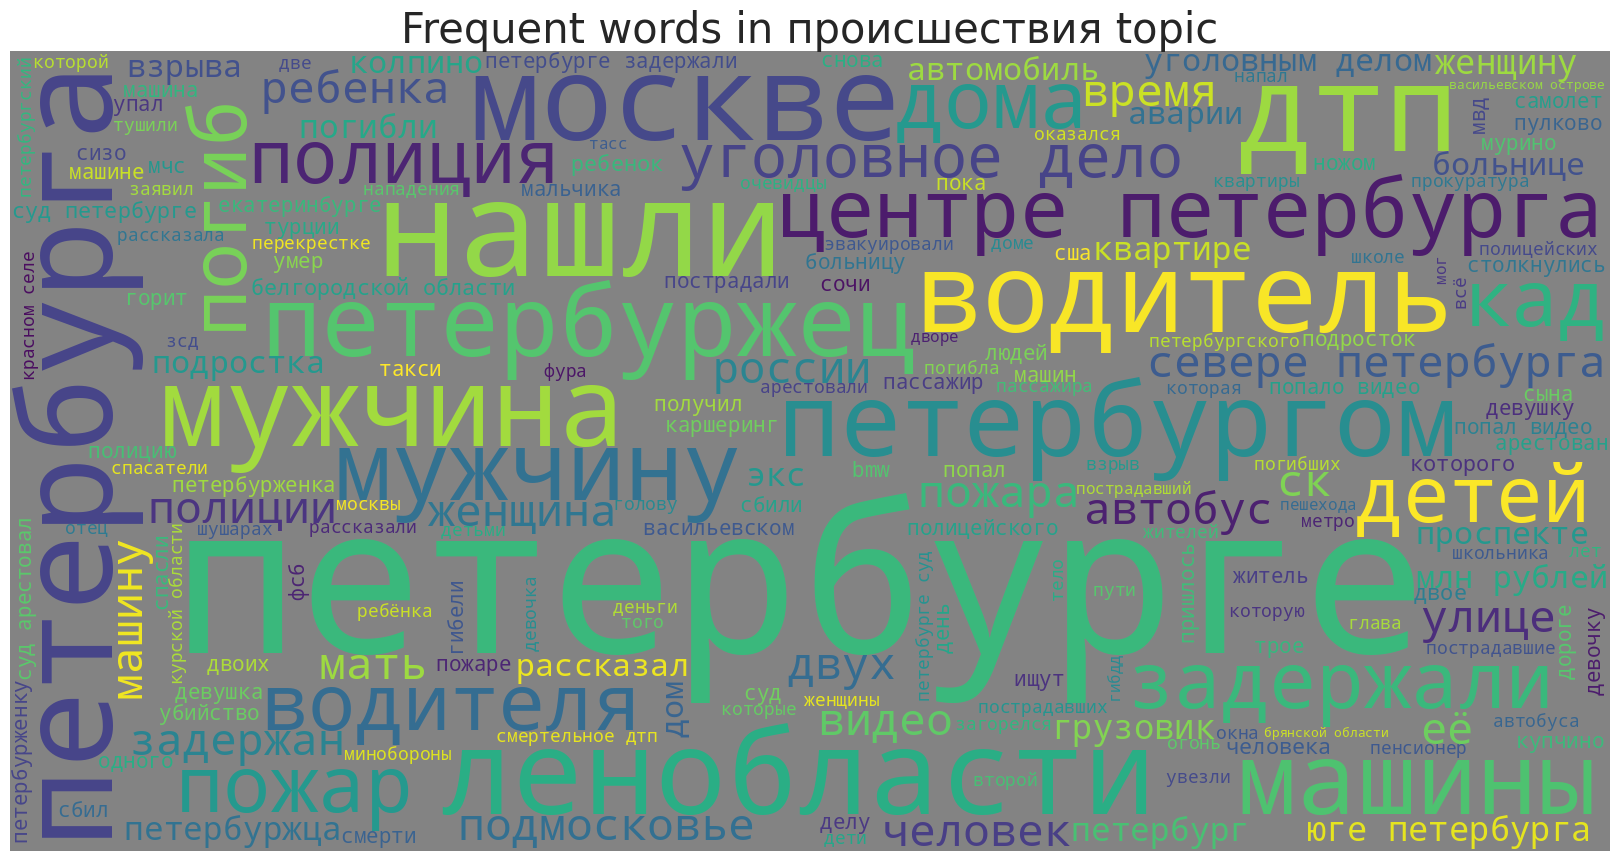

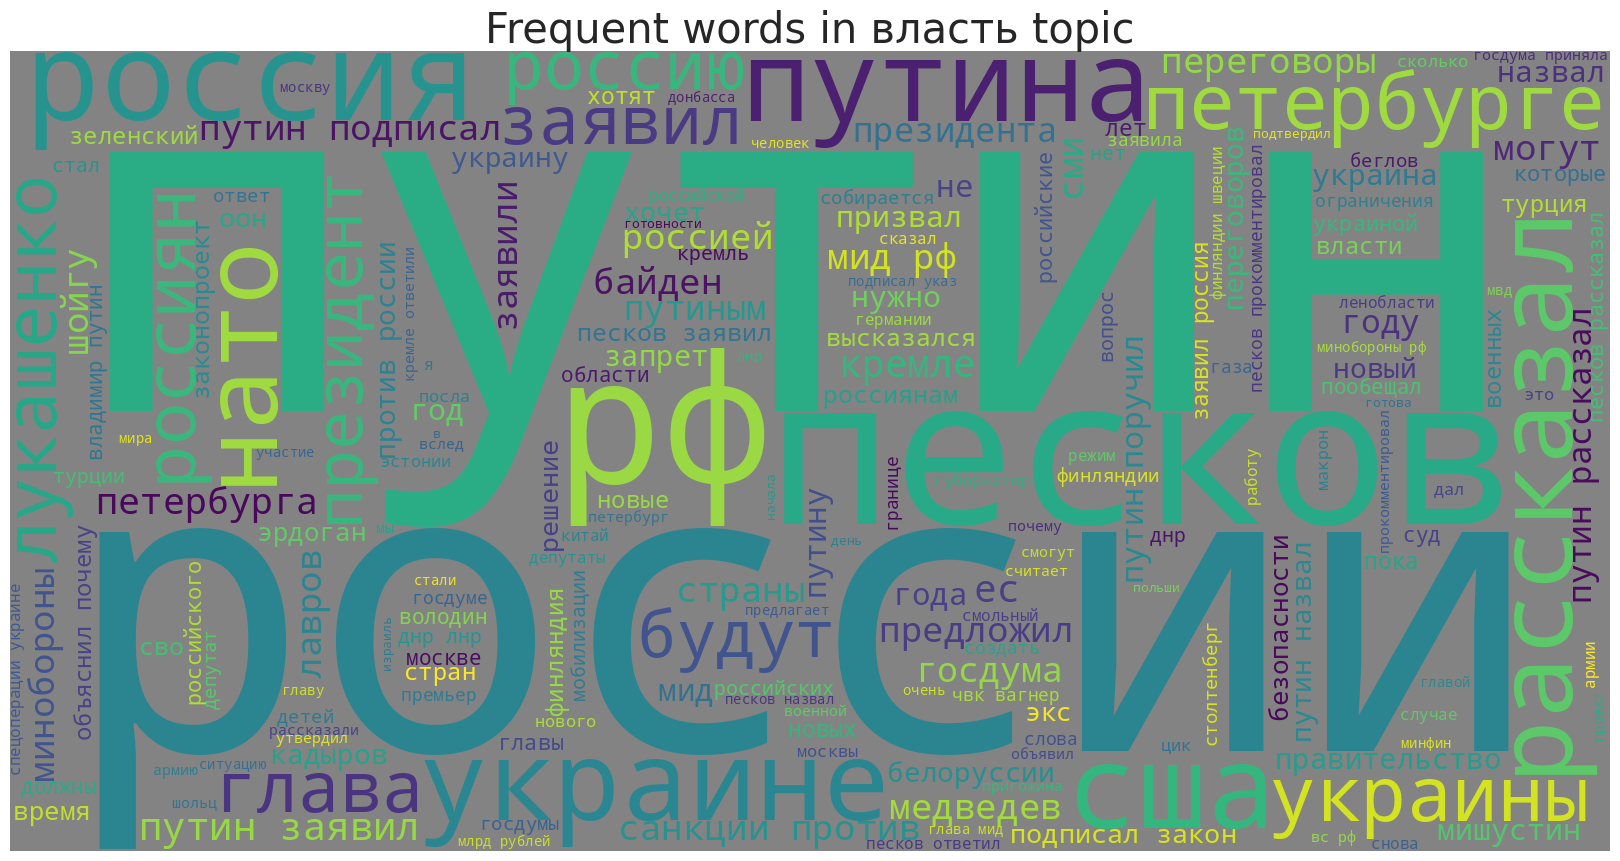

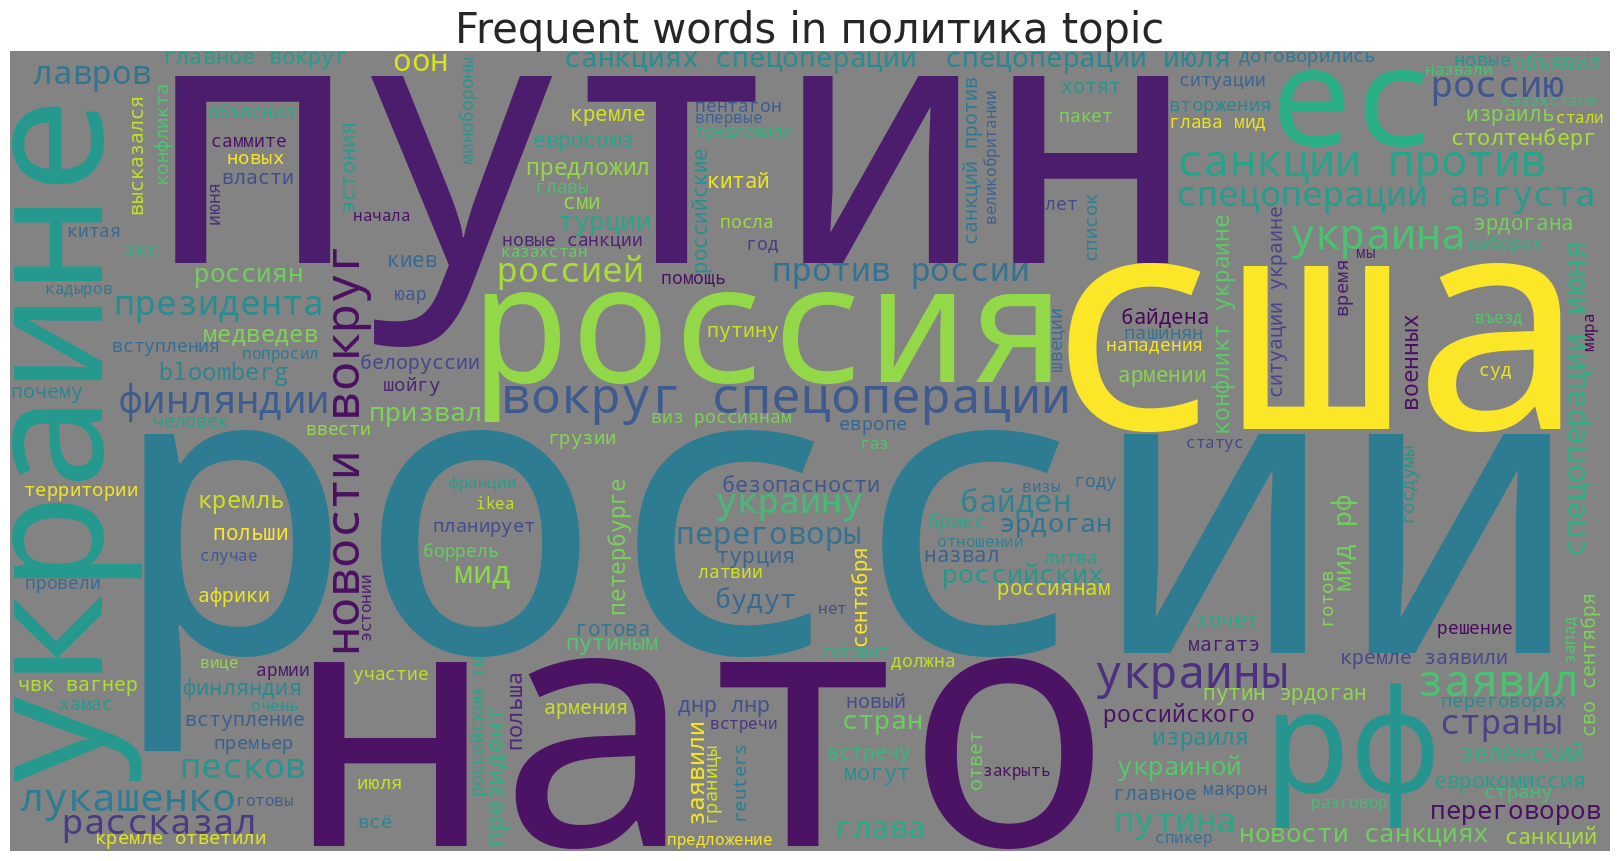

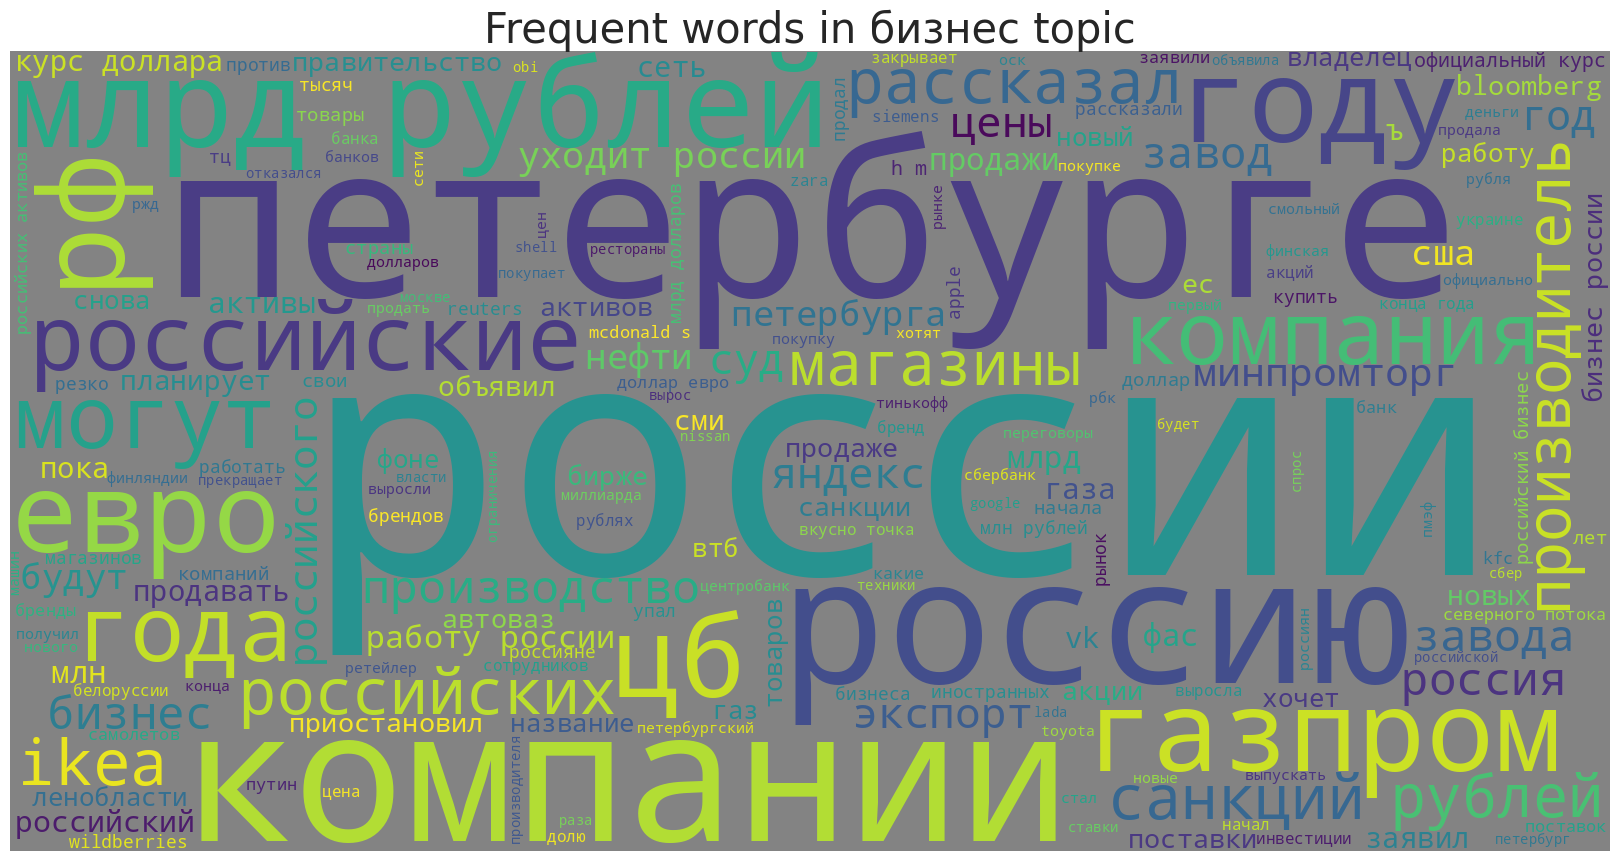

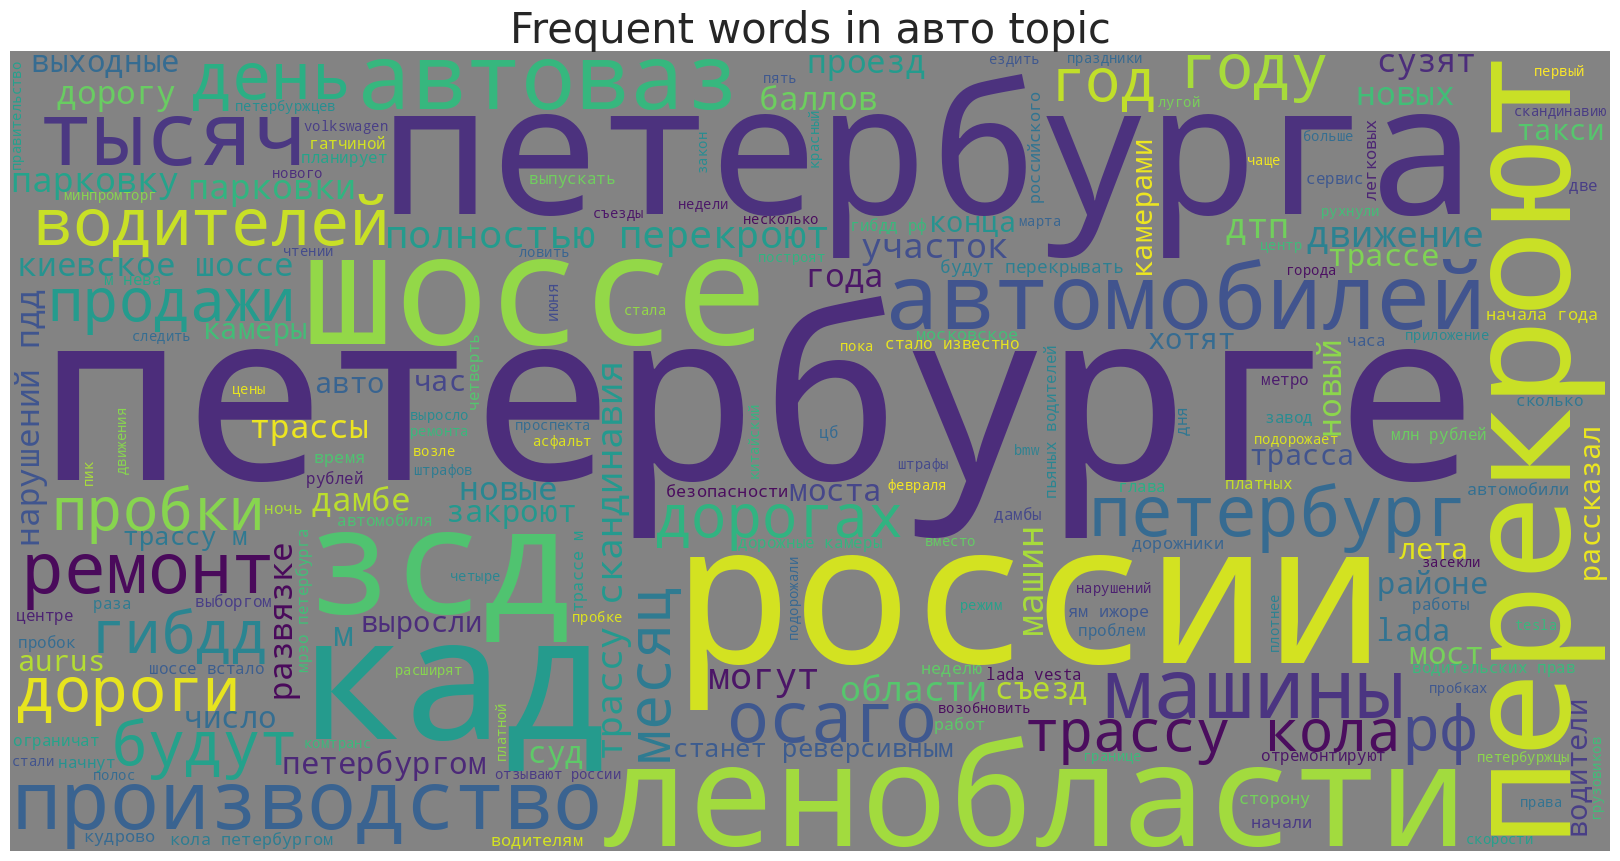

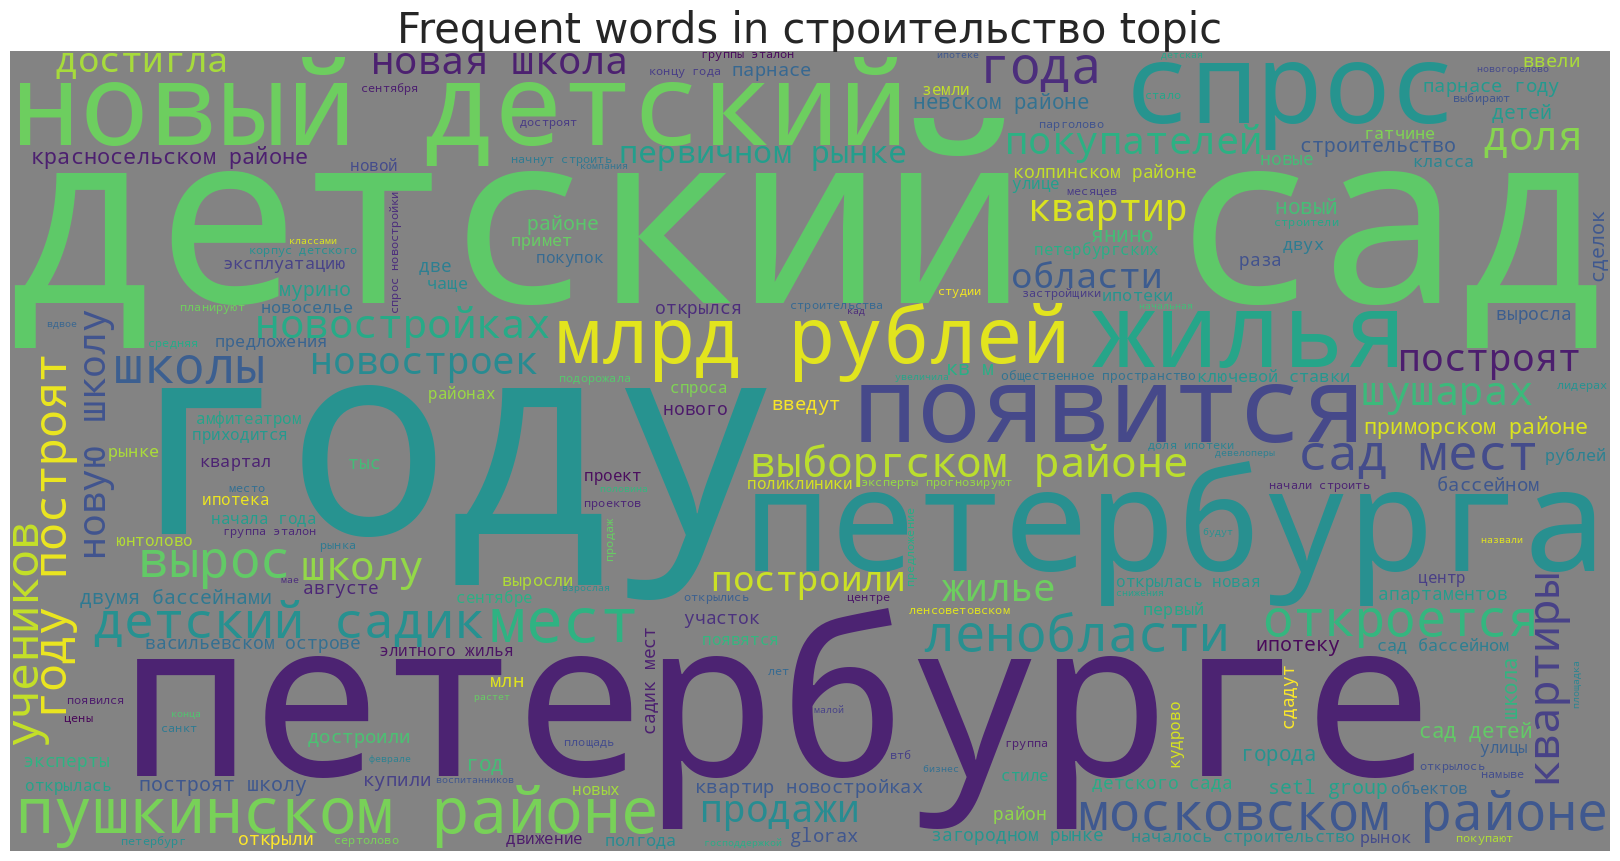

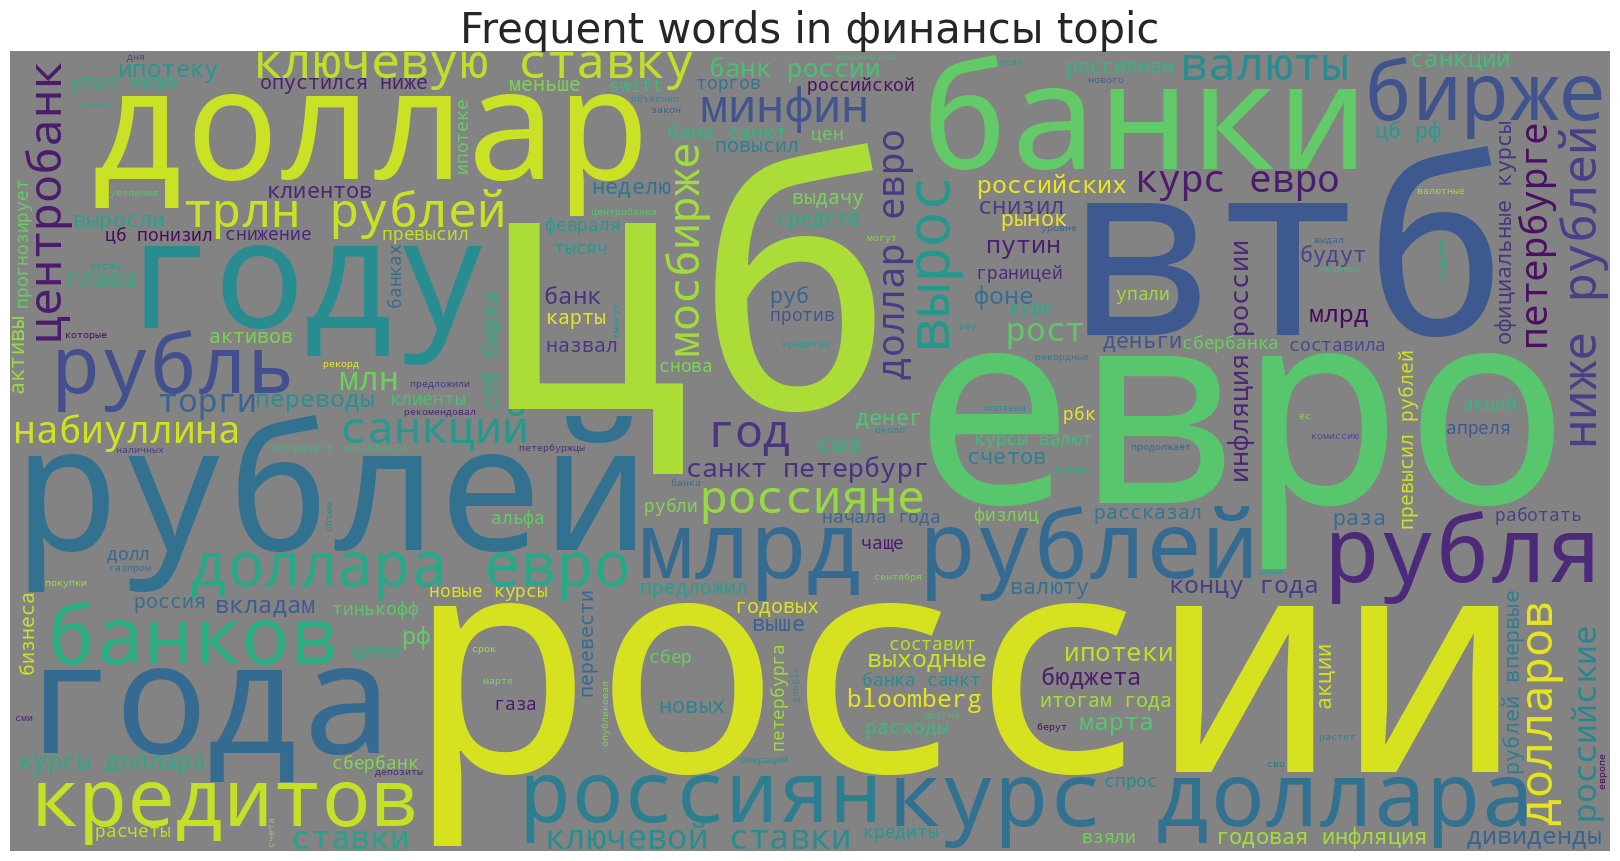

In [ ]:
for topic in df.topic.unique():
    words = df[df.topic == topic].title.str.split(' ').explode().values
    words = [word.lower() for word in words if word.lower() not in stop_words]

    wc = WordCloud(background_color="grey", width=1600, height=800)
    wc.generate(" ".join(words))

    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    plt.axis("off")
    plt.tight_layout(pad=0)
    ax.set_title(f"Frequent words in {topic} topic", fontsize=30)
    ax.imshow(wc, alpha=0.98)

**Выводы:**
- статьи разных тематик могут быть сильно похожи по доминирующим ключевым словам и тем самым негативно влиять на будущую модель

### Распределение по времени жизни

**Гипотеза:** есть зависимость количества просмотров в минуту

In [ ]:
df['lifetime'] = pd.to_datetime(df['datetime'], utc=True).apply(lambda x: (datetime.datetime.now(datetime.timezone.utc) - x).total_seconds())
df['lifetime'] = df['lifetime'].apply(lambda x: divmod(x, 60)[0]) # в минутах

В выборку попали статьи с разной временем жизни, т.е. как старые, так и совершенно новые статьи. Это влияет на количество просмотров. Поэтому для корректной работы модели необходимо будет каким-то образом отнормировать этот признак. Для этого сначала посмотрим распределение возраста статей, а затем распределение отношения количества просмотров к возрасту статьи.

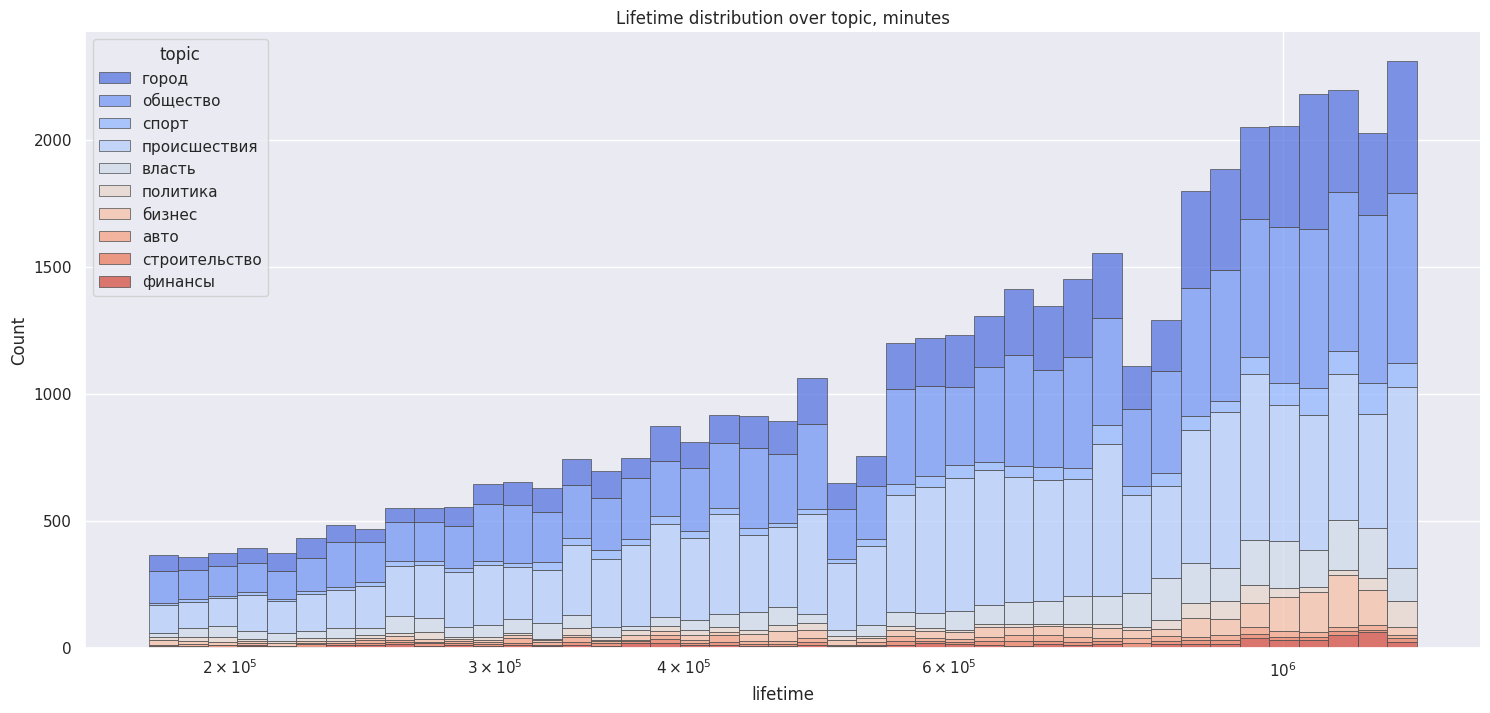

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(18, 8), dpi=100)
sns.despine(fig)

sns.histplot(
    df,
    x="lifetime",
    hue="topic",
    multiple="stack",
    edgecolor=".3",
    palette="coolwarm",
    linewidth=.5,
    log_scale=True,
);
axs.set_title('Распределение времени жизни по темам, в минутах');

в датасете присутствуют как старые статьи, так и новые

In [ ]:
df['views_by_minutes'] = (df['views'] + 1) / df['lifetime']
df['log_views_by_minutes'] = np.log1p(df['views_by_minutes'])

Новый признак: количество просмотров в минуту, или средняя скорость роста количества просмотров - имеет распределение, близкое к логнормальному.

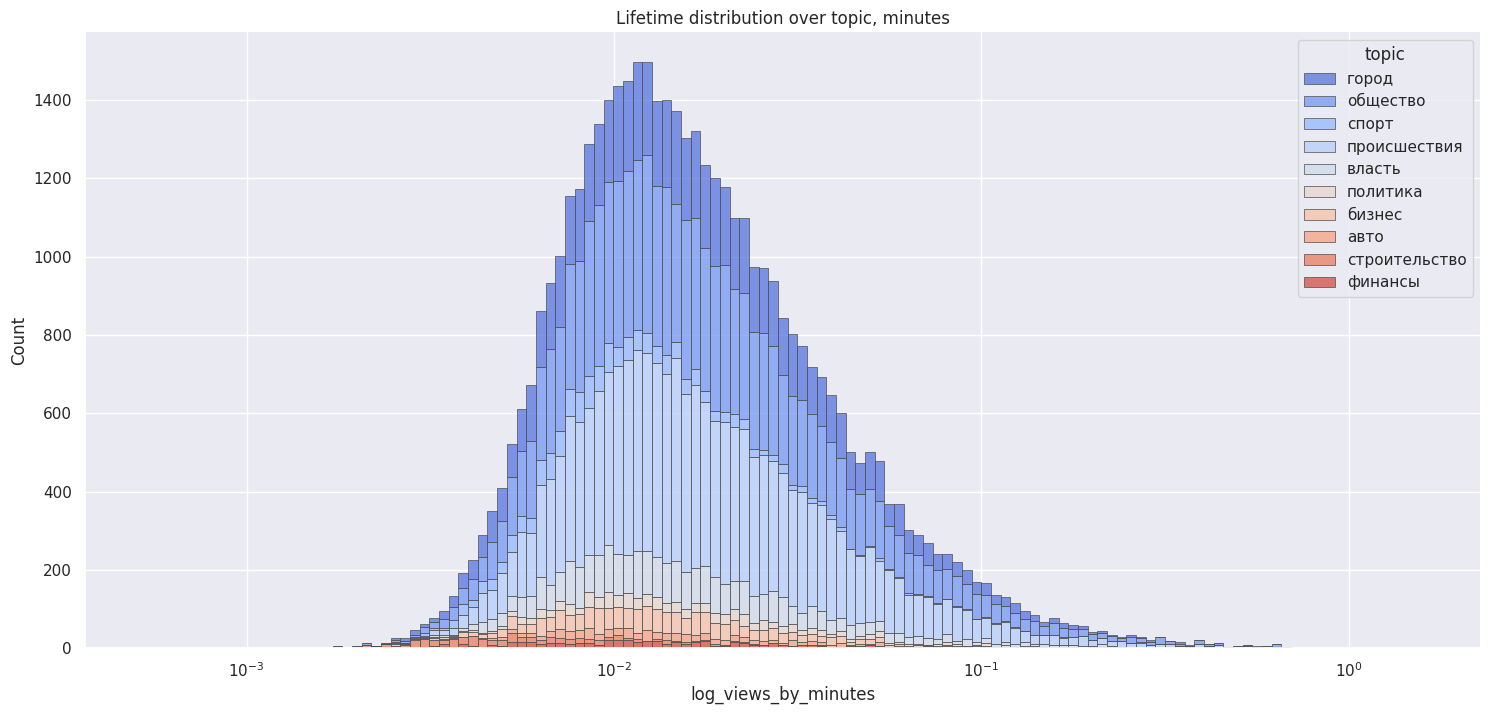

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(18, 8), dpi=100)
sns.despine(fig)

sns.histplot(
    df,
    x="log_views_by_minutes",
    hue="topic",
    multiple="stack",
    edgecolor=".3",
    palette="coolwarm",
    linewidth=.5,
    log_scale=True,
);
axs.set_title('Количество просмотров в минуту в логарифмическом масштабе');

**Выводы:**
- Одним из важных признаков является количество просмотров, поскольку в каждый период времени наиболее популярными будут статьи на актуальные для данного промежутка времени темы. Однако, количество просмотров сильно зависит от возраста статьи, поэтому мы добавили новый признак - средняя скорость роста количества просмотров.